In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import lmfit
import astropy
import astropy.units as u
import corner

In [2]:
from scipy import integrate

In [3]:
from astropy.cosmology import w0waCDM

In [4]:
def Hz1(z1,H01,Om1,Ode1,w01,wa1):
    cosmo = w0waCDM(H0=H01* u.km / u.s / u.Mpc, Om0=Om1,Ode0=Ode1,w0=w01,wa=wa1)
    E=cosmo.efunc(z1)
    HZ1=H01*E
    return HZ1

In [5]:
# def H_z(z,H0,Om,w0,w1):
#     # quad only accepts scalars, so need to use a list comprehension to run through the whole array of z
#     b= lambda zz : (1+w0+w1*(zz/(1+zz)))/(1+zz)
#     b1=[integrate.quadrature(b,0,zi) for zi in z]
#     # Returns a list, so we convert to a numpy array
#     B1=np.array(b1)
#     B2=B1.reshape(-1, 1)
#     x=(Om*(1+z)**3) + (1-Om)*np.exp(3*B1[:,0])
#     x1=np.array(x)
#     x2=x1.reshape(1,-1)
#     Hzz=H0*np.sqrt(x)
#     return Hzz

In [6]:
#Define  random redshifts
zs= np.linspace(0.01, 3., num=1000)

In [7]:
#From Planck observations for CPL mode
O_m = 0.3029
O_de = 1.0 - O_m
w_0 = -0.9414
w_1 = -0.4303
H_0 = 68.5265

In [8]:
#Hubble comoving parameter
# Hz=H_z(zs,H_0,O_m,w_0,w_1)/(1+zs)
Hz=Hz1(zs,H_0,O_m,O_de,w_0,w_1)/(1+zs)

In [9]:
Hz.shape

(1000,)

In [10]:
#random error for Hz
e1 = np.random.normal(0., 0.5, 1000)
errvec = 0.5 + np.zeros_like(e1)

In [11]:
H_zz= Hz + e1

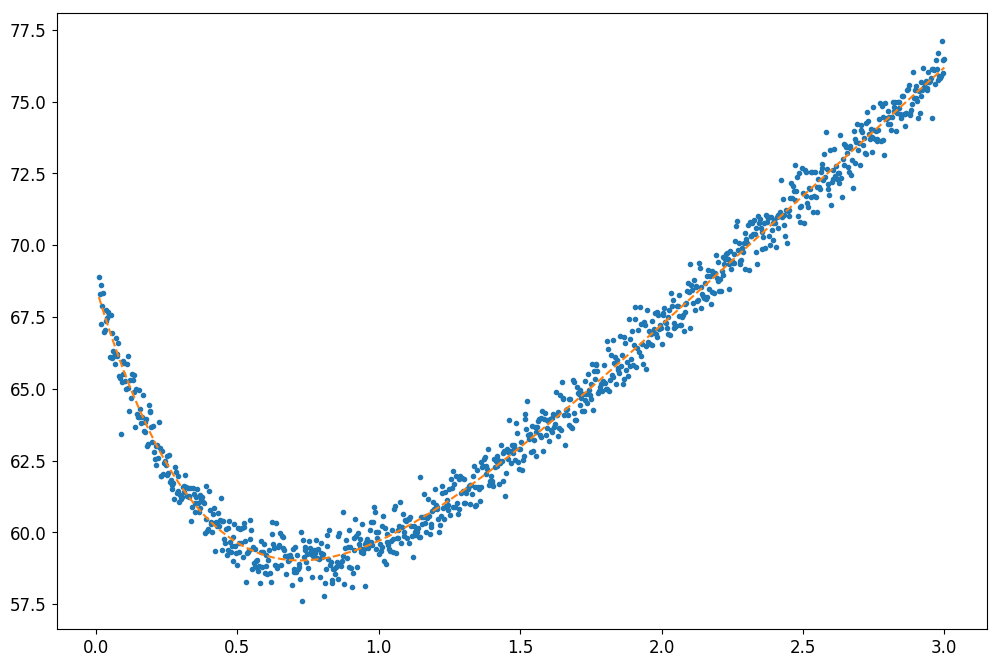

In [12]:
plt.plot(zs,H_zz, '.')
plt.plot(zs,Hz, '--')

In [13]:
p = lmfit.Parameters()
p.add_many(('Om1',0.3,True,0.,2.),
           ('H01',70.0,True,50.,100.),
           ('Ode1',0.7,True,0.,2.),
           ('w01',-1.0,True,-2.,2.),
           ('wa1',-0.1,True,-1.,1.))

def residual(p):
    v = p.valuesdict()
    return (Hz1(zs,v['H01'],v['Om1'],v['Ode1'],v['w01'],v['wa1'])-H_zz)/errvec

In [14]:
mi = lmfit.minimize(residual, p, method='nelder', nan_policy='omit')

/usr/local/lib/python3.7/site-packages/astropy/cosmology/core.py:877: RuntimeWarning: invalid value encountered in sqrt
  Ode0 * self.de_density_scale(z))
/usr/local/lib/python3.7/site-packages/numdifftools/limits.py:182: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  f_del = np.vstack(list(np.ravel(r)) for r in sequence)
/usr/local/lib/python3.7/site-packages/numdifftools/limits.py:184: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  for step in steps)


In [15]:
d = {'redshift': zs, 'Hubble_param': H_zz,'Hz_err':e1}

In [16]:
#create a panda dataframe in order to sort the values
df = pd.DataFrame(data=d)

In [17]:
dat = np.sort(df.T, axis=0)
z1 = df.redshift
Hzz1 = df.Hubble_param
e2 = df.Hz_err

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 2281
    # data points      = 1000
    # variables        = 5
    chi-square         = 1195.32320
    reduced chi-square = 1.20132985
    Akaike info crit   = 188.416613
    Bayesian info crit = 212.955389
[[Variables]]
    Om1:   1.4744e-13 +/- 4.2637e-09 (2891879.61%) (init = 0.3)
    H01:   69.0408741 +/- 0.07578621 (0.11%) (init = 70)
    Ode1:  0.99374913 +/- 9.1832e-04 (0.09%) (init = 0.7)
    w01:  -1.42795311 +/- 0.00319271 (0.22%) (init = -1)
    wa1:   0.99998424 +/- 1.4229e-05 (0.00%) (init = -0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(Ode1, w01) =  0.988
    C(H01, w01)  = -0.860
    C(H01, Ode1) = -0.779


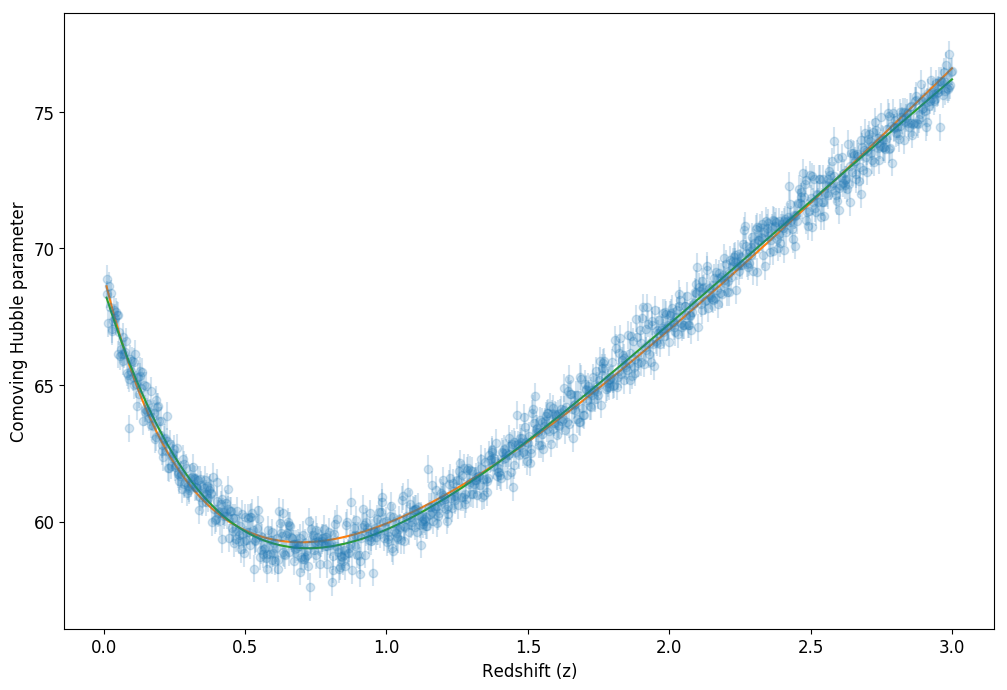

In [18]:
s = (z1.sort_values()).index
# plt.errorbar(z1[s],Hzz1[s],yerr=e2[s],fmt='o',alpha=0.2)
plt.errorbar(z1[s],Hzz1[s],yerr=errvec,fmt='o',alpha=0.2)
bestOm1 = mi.params.valuesdict()['Om1']
bestH01 = mi.params.valuesdict()['H01']
bestOde1= mi.params.valuesdict()['Ode1']
bestw01 = mi.params.valuesdict()['w01']
bestwa1 = mi.params.valuesdict()['wa1']
plt.plot(z1[s],Hz1(z1[s],bestH01,bestOm1,bestOde1,bestw01,bestwa1))
plt.plot(z1[s],Hz)
plt.xlabel('Redshift (z)')
plt.ylabel('Comoving Hubble parameter')
lmfit.report_fit(mi)

In [19]:
res = lmfit.minimize(residual, method='emcee', nan_policy='omit', burn=300, steps=1500,thin=1,
                         params=p, is_weighted=True)

/usr/local/lib/python3.7/site-packages/astropy/cosmology/core.py:877: RuntimeWarning: invalid value encountered in sqrt
  Ode0 * self.de_density_scale(z))


In [ ]:
corner.corner(res.flatchain,labels=mi.var_names, truths=list(mi.params.valuesdict().values()))